## Text Classification for Ham and Spam

Link for Data:- https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

In [609]:
import re
import nltk
import string
import pickle
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#nltk.download('stopwords')
#nltk.download('punkt')

In [610]:
from collections import Counter
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
import plotly.express as px
import plotly.graph_objs as go
from matplotlib import pyplot as plt

In [611]:
from sklearn.svm import SVC
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix

In [612]:
stop_words = set(stopwords.words('english'))

In [614]:
#df = pd.read_csv('data/kaggle_dataset.csv', encoding='ISO-8859-1')
df = pd.read_csv('data/kaggle_plus_personal_data.csv')
counts = Counter(df['target'])
print(df['target'].value_counts()/df.shape[0]*100)

ham     98.783348
spam     1.216652
Name: target, dtype: float64


In [615]:
def remove_text_from_brackets(text):
    text = re.sub("\(.*?\)", " ", text)
    text = text.strip()
    return text

def remove_special_character(text):
    text = re.sub('[^A-Za-z0-9]+', ' ', text)
    text = text.strip()
    return text

def remove_number(text):
    text = re.sub(r'[0-9]+', ' ', text)
    text = text.strip()
    return text

def remove_stop_words(text):
    word_tokens = word_tokenize(text)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    filtered_sentence = " ".join(filtered_sentence)
    return filtered_sentence

In [616]:
df['text'] = df['text'].apply(lambda x: str(x).lower())
df['text'] = df['text'].apply(remove_special_character)
df['text'] = df['text'].apply(remove_special_character)
df['text'] = df['text'].apply(remove_number)

In [617]:
df['num_char'] = df['text'].apply(len)
df['num_words']=df['text'].apply(lambda x: len(str(x).split()))
df = df[df['text'] != ""]

In [618]:
s1 = df[df['target'] == 'ham'].describe().reset_index()
s1.rename(columns={'index': 'prop' ,'num_char': 'num_char(ham)', 'num_words': 'num_words(ham)'}, inplace=True)
s2 = df[df['target'] == 'spam'].describe().reset_index()
s2.rename(columns={'index': 'prop' ,'num_char': 'num_char(spam)', 'num_words': 'num_words(spam)'}, inplace=True)
s_com = pd.merge(s1, s2, on=['prop'], how='left')
s_com =  s_com[['prop', 'num_char(ham)', 'num_char(spam)', 'num_words(ham)', 'num_words(spam)']]
s_com

prop  num_char(ham)  num_char(spam)  num_words(ham)  num_words(spam)
0  count   60247.000000      747.000000    60247.000000       747.000000
1   mean      48.453002       88.662651       10.323153        15.594378
2    std      50.364277       23.118850       10.239089         4.625969
3    min       1.000000        4.000000        1.000000         1.000000
4    25%      17.000000       78.000000        4.000000        13.000000
5    50%      34.000000       92.000000        7.000000        16.000000
6    75%      63.000000      104.500000       14.000000        19.000000
7    max     907.000000      142.000000      190.000000        26.000000

In [619]:
fig = px.histogram(df, x= 'num_char', color='target')
# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.update_layout(
    title="Number of Characters(Count)",
    xaxis_title="Number of Characters",
    yaxis_title="Count of Number of Characters"
)
fig.show()

In [620]:
fig = px.histogram(df, x= 'num_words', color='target')
# Overlay both histograms
fig.update_layout(barmode='overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.75)
fig.update_layout(
    title="Number of Words(Count)",
    xaxis_title="Number of Words",
    yaxis_title="Count of Number of Words"
)
fig.show()

In [621]:
fig = px.box(df['num_char'])
fig.update_layout(
    title="Boxplot for Number of Characters",
    xaxis_title="Number of Characters",
    yaxis_title="Values"
)
fig.show()

In [622]:
fig = px.box(df['num_words'])
fig.update_layout(
    title="Boxplot for Number of Words",
    xaxis_title="Number of Words",
    yaxis_title="Values"
)
fig.show()

In [623]:
# removing outlier based on number of characters
df = df[df['num_char'] < 468]

In [624]:
df['text'] = df['text'].apply(remove_stop_words)

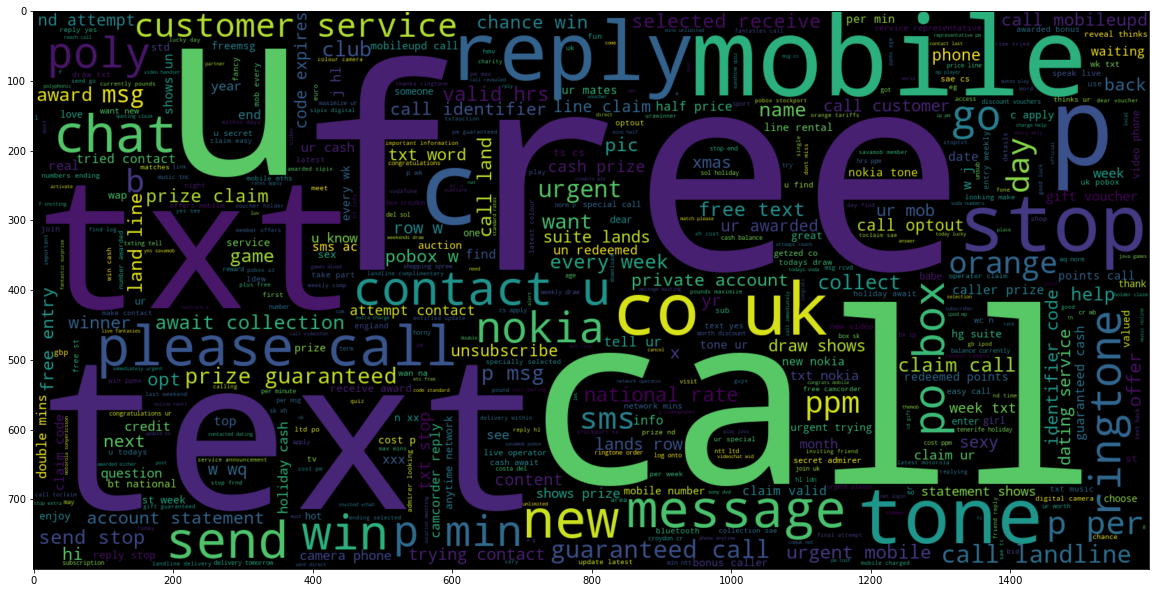

In [625]:
plt.figure(figsize = (20,20))
wc = WordCloud(width = 1600 , height = 800 , max_words = 500,background_color='black').generate(" ".join(df[df['target'] == 'spam'].text))
plt.imshow(wc , interpolation = 'bilinear')

In [462]:
plt.figure(figsize = (20,20)) # Text that is not fraudulent(0)
wc = WordCloud(width = 1600 , height = 800 , max_words = 500).generate(" ".join(df[df.target == 'ham'].text))
#plt.imshow(wc , interpolation = 'bilinear')

<Figure size 1440x1440 with 0 Axes>

In [626]:
le = preprocessing.LabelEncoder()
df['target'] = le.fit_transform(df['target'])

In [627]:
spam = ' '.join(df[df['target'] == 1]['text'].values)
spam_corpus = spam.split()

In [628]:
ham = ' '.join(df[df['target'] == 0]['text'].values)
ham_corpus = ham.split()

In [629]:
tfidf = TfidfVectorizer(max_features=3000)

In [630]:
X = tfidf.fit_transform(df['text']).toarray()
y = df['target'].values

In [631]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [632]:
model = SVC(kernel='sigmoid', gamma=1.0)
model.fit(X_train,y_train)

SVC(gamma=1.0, kernel='sigmoid')

In [633]:
y_pred = model.predict(X_test)

In [634]:
print("Accuracy Score: {}".format(accuracy_score(y_test, y_pred)*100))
print("Precision Score: {}".format(precision_score(y_test, y_pred)*100))

Accuracy Score: 99.54877348428911
Precision Score: 91.34615384615384


In [635]:
print(confusion_matrix(y_test, y_pred))

[[12039     9]
 [   46    95]]


In [636]:
model_path = 'saved_model/finalized_model.sav'
pickle.dump(model, open(model_path, 'wb'))

## Colculsion

1. Number of Chracters Count: spam has more character then ham.
2. Number of Words count: Spam has more number of words then ham, ham message is shorter and specific. 